In [99]:

import pandas as pd
import numpy as np
import warnings



import re
import os
import json

import plotly.express as px

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, accuracy_score, log_loss, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import KNNImputer

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import shap
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV

import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings("ignore")

In [111]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('tested.csv')
entire_df = pd.concat([train_df, test_df], axis = 0)


In [113]:
entire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


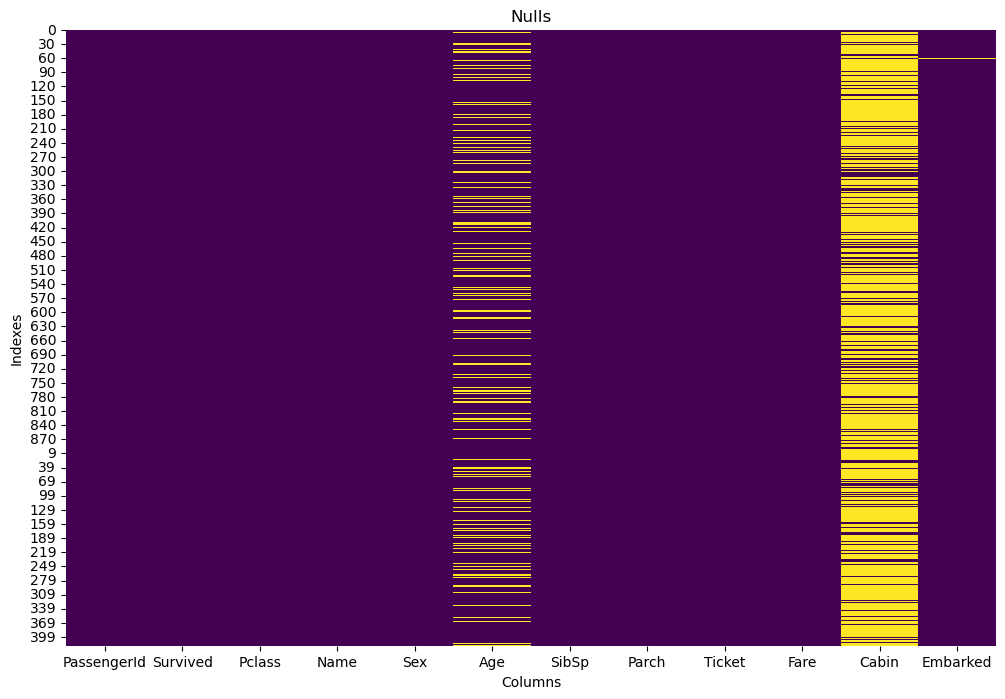

In [114]:
##check null values
missing_data = entire_df.isnull()
plt.figure(figsize=(12, 8))
sns.heatmap(missing_data, cbar=False, cmap='viridis', cbar_kws={'label': 'Missing Data'})
plt.title('Nulls')
plt.xlabel('Columns')
plt.ylabel('Indexes')
plt.show()

In [115]:
##### encoding block

# Title encoding
entire_df['Title'] = entire_df.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)
entire_df.Title = entire_df.Title.replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 
                                        'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
entire_df.Title = entire_df.Title.replace('Mlle', 'Miss')
entire_df.Title = entire_df.Title.replace('Ms', 'Miss')
entire_df.Title = entire_df.Title.replace('Mme', 'Mrs')


encoder_title = OneHotEncoder(sparse_output=False, drop='first')
title_encoded = encoder_title.fit_transform(entire_df[['Title']])
title_encoded_df = pd.DataFrame(title_encoded, columns=encoder_title.get_feature_names_out(['Title'])).astype(int)
# add title columns
for col in title_encoded_df.columns:
    entire_df[col] = title_encoded_df[col]


In [116]:
# Embarked encoding
## and filling nulls with mode 
most_frequent_embarked = entire_df['Embarked'].mode()[0]
entire_df['Embarked'].fillna(most_frequent_embarked, inplace=True)

encoder_embarked = OneHotEncoder(sparse_output=False, drop='first')
embarked_encoded = encoder_embarked.fit_transform(entire_df[['Embarked']])
embarked_encoded_df = pd.DataFrame(embarked_encoded, columns=encoder_embarked.get_feature_names_out(['Embarked'])).astype(int)

for col in embarked_encoded_df.columns:
    entire_df[col] = embarked_encoded_df[col]


In [117]:
# Sex encoding
encoder_Sex = OneHotEncoder(sparse_output=False, drop='first')
sex_encoded = encoder_Sex.fit_transform(entire_df[['Sex']])
sex_encoded_df = pd.DataFrame(sex_encoded, columns=encoder_Sex.get_feature_names_out(['Sex'])).astype(int)

for col in sex_encoded_df.columns:
    entire_df[col] = sex_encoded_df[col]

Text(0.5, 1.0, 'Age Distribution')

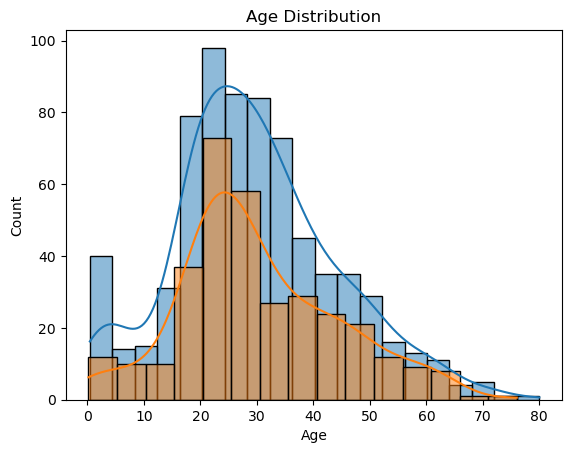

In [118]:
sns.histplot(data=train_df['Age'], kde=True)
plt.title('Age Distribution')


sns.histplot(data=test_df['Age'], kde=True)
plt.title('Age Distribution')

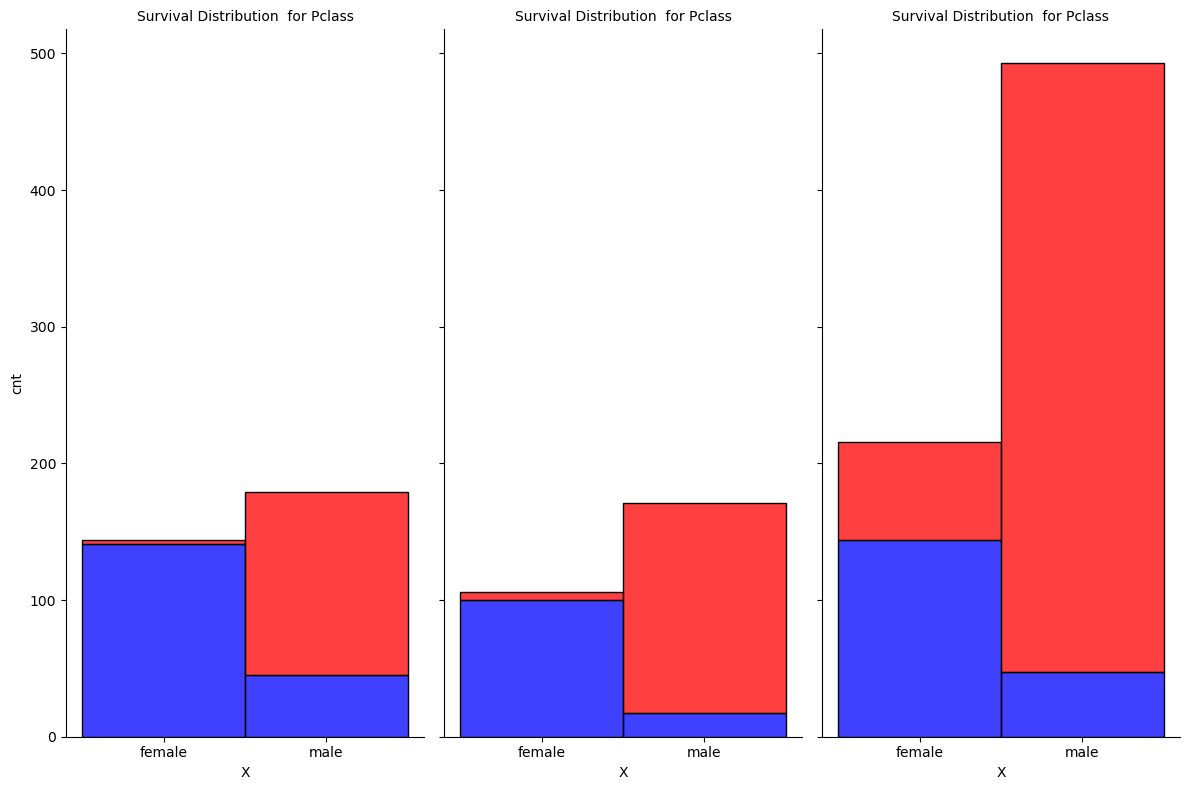

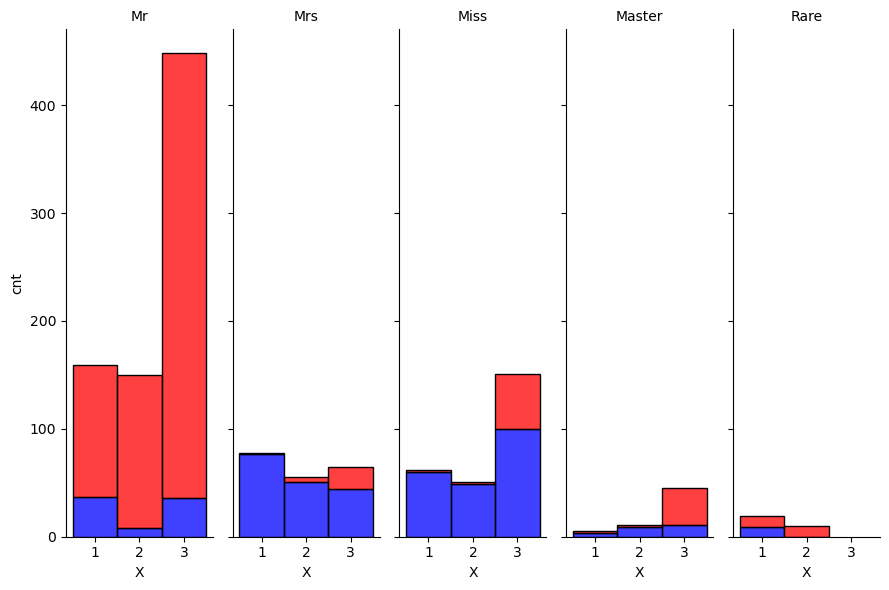

In [51]:

g = sns.FacetGrid(entire_df, col='Title', height=6, aspect=0.3)


g.map_dataframe(sns.histplot, x='Pclass', bins=2, hue='Survived', multiple="stack", kde=False, discrete=True
                ,palette={0: 'red', 1: 'blue'})
g.set_axis_labels('X', 'cnt')
g.set_titles('{col_name}')
plt.show()

In [119]:
## familty size
entire_df['Family_Size'] = entire_df['Parch'] + entire_df['SibSp']

In [138]:
## family survival
entire_df['Last_Name'] = entire_df['Name'].apply(lambda x: str.split(x, ",")[0])
entire_df['Fare'].fillna(entire_df['Fare'].mean(), inplace=True)

default_value = 0.5
entire_df['Family_Survival'] = default_value

for grp, grp_df in entire_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                entire_df.loc[entire_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                entire_df.loc[entire_df['PassengerId'] == passID, 'Family_Survival'] = 0
                
for _, grp_df in entire_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    entire_df.loc[entire_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    entire_df.loc[entire_df['PassengerId'] == passID, 'Family_Survival'] = 0

Text(0.5, 1.0, 'Fare Distribution')

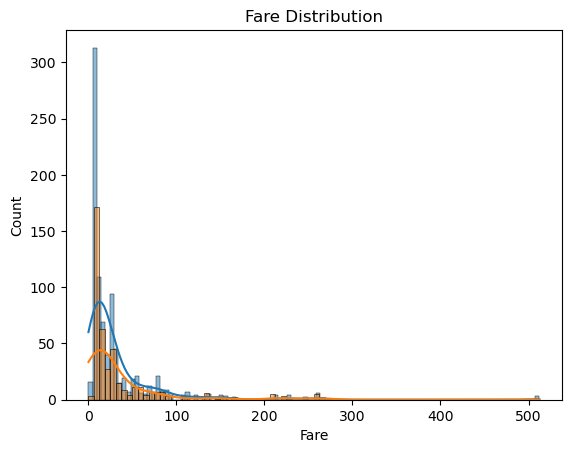

In [139]:
sns.histplot(data=train_df['Fare'], kde=True)
plt.title('Fare Distribution')


sns.histplot(data=test_df['Fare'], kde=True )
plt.title('Fare Distribution')

In [122]:
for _ in [5,25,50,75, 90, 99]:
    print (np.percentile(entire_df['Fare'], _))

7.225
7.8958
14.4542
31.275
78.01998
262.375


In [129]:
### lets get fare into bins

entire_df['Fare'].fillna(entire_df['Fare'].median(), inplace = True)

# Making Bins
entire_df['FareBin'] = pd.qcut(entire_df['Fare'], 5)

label = LabelEncoder()
entire_df['FareBin_Code'] = label.fit_transform(entire_df['FareBin'])

In [130]:
### age bins 
entire_df['AgeBin'] = pd.qcut(entire_df['Age'], 4)

label = LabelEncoder()
entire_df['AgeBin_Code'] = label.fit_transform(entire_df['AgeBin'])

In [140]:
train_df = entire_df[:891]
test_df = entire_df[891:]

In [141]:


X_train = train_df[['FareBin_Code',  'Family_Survival', 'AgeBin_Code', 'Family_Size', 'Pclass', 'Sex_male']]
Y_train = train_df['Survived']




X_test = test_df[['FareBin_Code',  'Family_Survival', 'AgeBin_Code', 'Family_Size', 'Pclass', 'Sex_male']]


Y_test = test_df['Survived']

Random Forest:
  Accuracy (Train): 89.45%
  Accuracy (Test): 58.85%
  Log Loss (Train): 0.2512
  Log Loss (Test): 1.9045
--------------------------------------------------
SGD:
  Accuracy (Train): 75.42%
  Accuracy (Test): 50.96%
  Log Loss (Train): 0.6088
  Log Loss (Test): 1.6446
--------------------------------------------------
Linear SVC:
  Accuracy (Train): 81.48%
  Accuracy (Test): 55.50%
  Log Loss (Train): 4.6861
  Log Loss (Test): 8.2042
--------------------------------------------------
KNN:
  Accuracy (Train): 86.31%
  Accuracy (Test): 60.77%
  Log Loss (Train): 0.6759
  Log Loss (Test): 4.3886
--------------------------------------------------
Gaussian Naive Bayes:
  Accuracy (Train): 78.23%
  Accuracy (Test): 54.55%
  Log Loss (Train): 0.4649
  Log Loss (Test): 1.1346
--------------------------------------------------
SVC:
  Accuracy (Train): 82.94%
  Accuracy (Test): 55.50%
  Log Loss (Train): 0.4167
  Log Loss (Test): 0.8949
---------------------------------------------

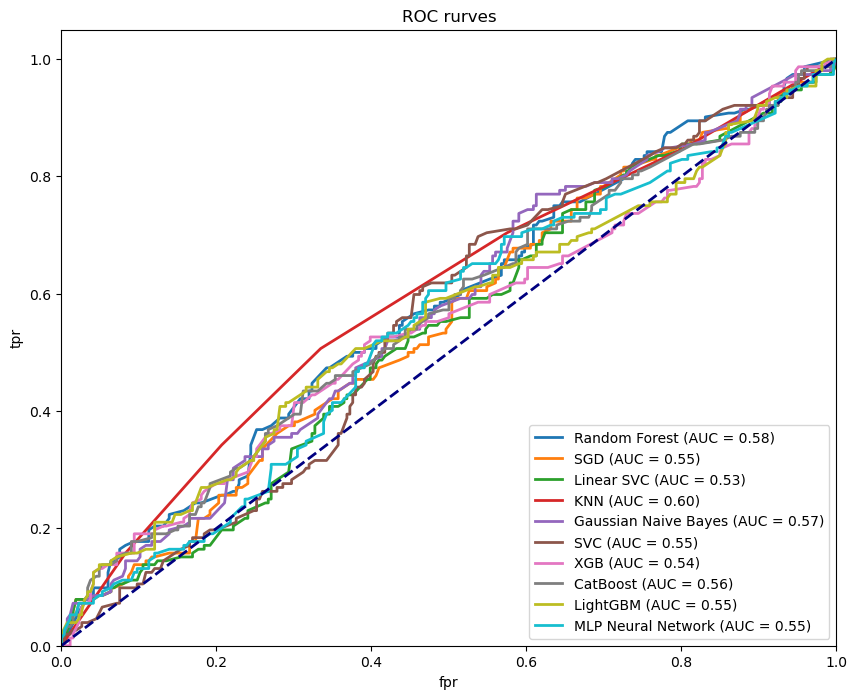

In [142]:
class ModelEvaluator:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.models = [
            ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
                        ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

    def calculate_log_loss(self, model):
        if hasattr(model, "predict_proba"):
            probas_train = model.predict_proba(self.X_train)
            probas_test = model.predict_proba(self.X_test)
        else:
            probas_train = model.decision_function(self.X_train)
            probas_test = model.decision_function(self.X_test)

        log_loss_train = log_loss(self.Y_train, probas_train)
        log_loss_test = log_loss(self.Y_test, probas_test)
        return log_loss_train, log_loss_test


    def train_and_evaluate_models(self):
        for name, model in self.models:
            model.fit(self.X_train, self.Y_train)
            
            # Accuracy
            acc_train = accuracy_score(self.Y_train, model.predict(self.X_train)) * 100
            acc_test = accuracy_score(self.Y_test, model.predict(self.X_test)) * 100
            
            # Log Loss
            log_loss_train, log_loss_test = self.calculate_log_loss(model)
            
            # Print results
            print(f"{name}:")
            print(f"  Accuracy (Train): {acc_train:.2f}%")
            print(f"  Accuracy (Test): {acc_test:.2f}%")
            print(f"  Log Loss (Train): {log_loss_train:.4f}")
            print(f"  Log Loss (Test): {log_loss_test:.4f}")
            print("-" * 50)
        
    

    def plot_roc_curve(self):
        plt.figure(figsize=(10, 8))

        for name, model in self.models:
            if hasattr(model, "predict_proba"):
                probas_ = model.predict_proba(self.X_test)[:, 1]
            else:
                probas_ = model.decision_function(self.X_test)

            fpr, tpr, _ = roc_curve(self.Y_test, probas_)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        # random roc to compare
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC rurves')
        plt.legend(loc="lower right")
        plt.show()


evaluator = ModelEvaluator(X_train, Y_train, X_test, Y_test)
evaluator.train_and_evaluate_models()
evaluator.plot_roc_curve()

KNeighborsClassifier()

In [392]:

models = [
 ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
            ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]


# Initialize lists to store the metrics
precision_train_list = []
precision_test_list = []
recall_train_list = []
recall_test_list = []
f1_train_list = []
f1_test_list = []
roc_auc_train_list = []
roc_auc_test_list = []
model_names = []
acc_train_list = []
acc_test_list = []
log_loss_train_list = []
log_loss_test_list = []

# Iterate through models and compute metrics
for name, model in models:
    try:
        model.fit(X_train, Y_train)
        
        # Accuracy
        acc_train = accuracy_score(Y_train, model.predict(X_train)) * 100
        acc_test = accuracy_score(Y_test, model.predict(X_test)) * 100
        
        # Log Loss
        log_loss_train, log_loss_test = calculate_log_loss(model, X_train, Y_train, X_test, Y_test)
        
        # Precision
        precision_train = precision_score(Y_train, model.predict(X_train))
        precision_test = precision_score(Y_test, model.predict(X_test))
        
        # Recall
        recall_train = recall_score(Y_train, model.predict(X_train))
        recall_test = recall_score(Y_test, model.predict(X_test))
        
        # F1-Score
        f1_train = f1_score(Y_train, model.predict(X_train))
        f1_test = f1_score(Y_test, model.predict(X_test))
        
        # ROC AUC
        if hasattr(model, "predict_proba"):
            roc_auc_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
            roc_auc_test = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])
        else:
            roc_auc_train = roc_auc_score(Y_train, model.decision_function(X_train))
            roc_auc_test = roc_auc_score(Y_test, model.decision_function(X_test))
        
        # Append the model name and metrics to the lists
        model_names.append(name)
        precision_train_list.append(precision_train)
        precision_test_list.append(precision_test)
        recall_train_list.append(recall_train)
        recall_test_list.append(recall_test)
        f1_train_list.append(f1_train)
        f1_test_list.append(f1_test)
        roc_auc_train_list.append(roc_auc_train)
        roc_auc_test_list.append(roc_auc_test)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        log_loss_train_list.append(log_loss_train)
        log_loss_test_list.append(log_loss_test)
        
    except Exception as e:
        # In case of any error, append np.nan or a default value
        print(f"Error with model {name}: {e}")
        model_names.append(name)
        precision_train_list.append(np.nan)
        precision_test_list.append(np.nan)
        recall_train_list.append(np.nan)
        recall_test_list.append(np.nan)
        f1_train_list.append(np.nan)
        f1_test_list.append(np.nan)
        roc_auc_train_list.append(np.nan)
        roc_auc_test_list.append(np.nan)
        
        acc_train_list.append(np.nan)
        acc_test_list.append(np.nan)
        log_loss_train_list.append(np.nan)
        log_loss_test_list.append(np.nan)

# Create DataFrame for model comparison
models_comparison = pd.DataFrame({
    'Model': model_names,
    'Score_train': acc_train_list,
    'Score_test': acc_test_list,
    'LogLoss_train': log_loss_train_list,
    'LogLoss_test': log_loss_test_list,
    'Precision_train': precision_train_list,
    'Precision_test': precision_test_list,
    'Recall_train': recall_train_list,
    'Recall_test': recall_test_list,
    'F1_train': f1_train_list,
    'F1_test': f1_test_list,
    'ROC_AUC_train': roc_auc_train_list,
    'ROC_AUC_test': roc_auc_test_list
})

# Sort the models by test accuracy
models_comparison = models_comparison.sort_values(by='Score_test', ascending=False)
models_comparison






,Model,Score_train,Score_test,LogLoss_train,LogLoss_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,ROC_AUC_train,ROC_AUC_test
1,SGD,81.930415,95.933014,0.433846,0.207644,0.790997,0.941176,0.719298,0.947368,0.753446,0.944262,0.870336,0.984369
5,SVC,84.624018,95.454545,0.398463,0.245380,0.847458,0.946309,0.730994,0.927632,0.784929,0.936877,0.891342,0.971953
2,Linear SVC,83.052750,94.736842,4.491971,1.292792,0.837456,0.933333,0.692982,0.921053,0.758400,0.927152,0.875907,0.983083
9,MLP Neural Network,84.624018,93.062201,0.367162,0.260549,0.852234,0.930070,0.725146,0.875000,0.783570,0.901695,0.898899,0.966314
3,KNN,86.195286,90.191388,0.623689,0.598651,0.889680,0.905109,0.730994,0.815789,0.802568,0.858131,0.905386,0.932875
7,CatBoost,87.991021,89.952153,0.280058,0.304143,0.909408,0.887324,0.763158,0.828947,0.829889,0.857143,0.947872,0.929313
8,LightGBM,87.654321,89.234450,0.284549,0.309644,0.914286,0.868966,0.748538,0.828947,0.823151,0.848485,0.943590,0.931144
6,XGB,88.439955,88.755981,0.261995,0.364336,0.916376,0.867133,0.769006,0.815789,0.836248,0.840678,0.953358,0.903097
0,Random Forest,88.664422,88.277512,0.256927,0.327660,0.903010,0.850340,0.789474,0.822368,0.842434,0.836120,0.954375,0.924651
4,Gaussian Naive Bayes,78.787879,84.928230,0.468280,0.403684,0.685230,0.719212,0.827485,0.960526,0.749669,0.822535,0.860696,0.913954


In [208]:
import optuna

In [209]:
##catboost validation + optuna
X_train_split, X_eval, Y_train_split, Y_eval = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 2, 7),
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 10),
    }


    model = CatBoostClassifier(**param, verbose=0)


    model.fit(X_train_split, Y_train_split, eval_set=(X_eval, Y_eval), early_stopping_rounds=50)


    y_pred_proba = model.predict_proba(X_test) 


    loss = log_loss(Y_test, y_pred_proba)
    
    return loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print('Best hyperparameters:', study.best_params)
print('Best log_loss:', study.best_value)


best_params = study.best_params
final_model = CatBoostClassifier(**best_params, verbose=0)
final_model.fit(X_train, Y_train)


predictions = final_model.predict(X_test)
print("Predictions on test dataset:", predictions)


vis.plot_param_importances(study)

[I 2024-12-04 23:31:35,471] A new study created in memory with name: no-name-1d8a99c7-daee-4a2a-ba95-12ac89ccf178


[I 2024-12-04 23:31:35,661] Trial 0 finished with value: 0.3392371974685728 and parameters: {'learning_rate': 0.27294957774620243, 'depth': 6, 'iterations': 781, 'reg_lambda': 3.130919849628908}. Best is trial 0 with value: 0.3392371974685728.
[I 2024-12-04 23:31:36,220] Trial 1 finished with value: 0.3271993390970891 and parameters: {'learning_rate': 0.011444284987167357, 'depth': 5, 'iterations': 1167, 'reg_lambda': 1.383627773815983}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:36,401] Trial 2 finished with value: 0.35385351406016624 and parameters: {'learning_rate': 0.24215885958400366, 'depth': 4, 'iterations': 627, 'reg_lambda': 8.728587391354395}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:36,557] Trial 3 finished with value: 0.357026024798522 and parameters: {'learning_rate': 0.13831164417100594, 'depth': 4, 'iterations': 1952, 'reg_lambda': 1.6438906376558426}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:

Best hyperparameters: {'learning_rate': 0.2014577786654323, 'depth': 7, 'iterations': 1015, 'reg_lambda': 9.683956200134041}
Best log_loss: 0.3046558830988605
Predictions on test dataset: [1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1
 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1]


In [408]:
submission = pd.DataFrame({
        "PassengerId": pd.read_csv('test.csv')['PassengerId'],
        "Survived": y_pred
    })
submission.to_csv('submission_xgb.csv', index=False)

In [143]:
m = xgb.XGBClassifier()
m.fit(X_train, Y_train)
accuracy_score(Y_test, m.predict(X_test))

0.5765550239234449